In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'BNB'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,2.05314,2.17423,1.89394,1.99077,1.99077,19192200
2017-11-10,2.00773,2.06947,1.64478,1.79684,1.79684,11155000
2017-11-11,1.78628,1.91775,1.61429,1.67047,1.67047,8178150
2017-11-12,1.66889,1.67280,1.46256,1.51969,1.51969,15298700
2017-11-13,1.52601,1.73502,1.51760,1.68662,1.68662,12238800


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-15,566.707031,587.421509,561.127258,582.074341,582.074341,1895100260
2024-05-16,582.100159,586.436340,565.762329,569.190247,569.190247,1911862000
2024-05-17,569.190247,584.666016,568.836731,581.178345,581.178345,1557134929
2024-05-18,581.180000,581.990000,575.020000,580.480000,580.480000,1358737176
2024-05-19,580.480000,581.880000,572.370000,574.630000,574.630000,1298887094


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

574.63

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998961,0.998346,0.997836,0.997836,0.640256
High,0.998961,1.000000,0.997673,0.998916,0.998916,0.660955
Low,0.998346,0.997673,1.000000,0.998788,0.998788,0.619373
Close,0.997836,0.998916,0.998788,1.000000,1.000000,0.644902
Adj Close,0.997836,0.998916,0.998788,1.000000,1.000000,0.644902
Volume,0.640256,0.660955,0.619373,0.644902,0.644902,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,1.990770,19192200
2017-11-10,1.796840,11155000
2017-11-11,1.670470,8178150
2017-11-12,1.519690,15298700
2017-11-13,1.686620,12238800
...,...,...
2024-05-15,582.074341,1895100260
2024-05-16,569.190247,1911862000
2024-05-17,581.178345,1557134929


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,9.32141,109298000,6.562748,4.183277,3.186518
2017-12-29,8.80760,70849400,6.864275,4.418480,3.322854
2017-12-30,7.84101,72933904,7.130755,4.613281,3.443738
2017-12-31,8.63558,74927904,7.476312,4.832126,3.583040
2018-01-01,8.41461,66422800,7.884158,5.043141,3.720938


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-15,582.074341,1895100260,586.265454,582.626591,582.684404
2024-05-16,569.190247,1911862000,584.336884,583.671954,582.577977
2024-05-17,581.178345,1557134929,584.706098,585.230699,582.536127
2024-05-18,580.480000,1358737176,583.934353,586.174295,581.892568
2024-05-19,574.630000,1298887094,581.794154,586.832319,581.364840


<Axes: xlabel='Date'>

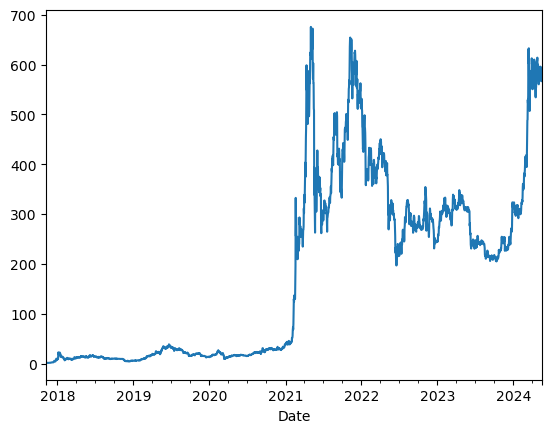

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,1.990770,19192200
1,2017-11-10,1.796840,11155000
2,2017-11-11,1.670470,8178150
3,2017-11-12,1.519690,15298700
4,2017-11-13,1.686620,12238800
...,...,...,...
2379,2024-05-15,582.074341,1895100260
2380,2024-05-16,569.190247,1911862000
2381,2024-05-17,581.178345,1557134929
2382,2024-05-18,580.480000,1358737176


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2469,2024-08-13
2470,2024-08-14
2471,2024-08-15
2472,2024-08-16
2473,2024-08-17


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2444,2024-07-19,417.627559,308.410750,456.806022,411.218317,422.625904,-32.759500,-32.759500,-32.759500,0.375509,0.375509,0.375509,-33.135009,-33.135009,-33.135009,0.0,0.0,0.0,384.868059
2445,2024-07-20,417.953896,310.981276,454.786168,411.277288,423.183488,-32.780222,-32.780222,-32.780222,0.012327,0.012327,0.012327,-32.792549,-32.792549,-32.792549,0.0,0.0,0.0,385.173674
2446,2024-07-21,418.280233,315.031589,464.461000,411.108334,423.750069,-31.956986,-31.956986,-31.956986,0.524419,0.524419,0.524419,-32.481404,-32.481404,-32.481404,0.0,0.0,0.0,386.323247
2447,2024-07-22,418.606570,315.847795,455.571254,410.915078,424.296106,-32.613633,-32.613633,-32.613633,-0.416937,-0.416937,-0.416937,-32.196696,-32.196696,-32.196696,0.0,0.0,0.0,385.992937
2448,2024-07-23,418.932907,311.229780,464.669204,410.953262,424.899093,-32.500272,-32.500272,-32.500272,-0.568646,-0.568646,-0.568646,-31.931626,-31.931626,-31.931626,0.0,0.0,0.0,386.432635
2449,2024-07-24,419.259244,310.505317,463.042757,411.046607,425.408724,-31.619984,-31.619984,-31.619984,0.057759,0.057759,0.057759,-31.677744,-31.677744,-31.677744,0.0,0.0,0.0,387.639260
2450,2024-07-25,419.585581,316.593062,463.704714,411.151256,426.066182,-31.409705,-31.409705,-31.409705,0.015569,0.015569,0.015569,-31.425274,-31.425274,-31.425274,0.0,0.0,0.0,388.175876
2451,2024-07-26,419.911918,314.835607,465.445587,411.284483,426.589906,-30.787976,-30.787976,-30.787976,0.375509,0.375509,0.375509,-31.163485,-31.163485,-31.163485,0.0,0.0,0.0,389.123942
2452,2024-07-27,420.238255,316.035809,462.638413,411.300188,427.113630,-30.868762,-30.868762,-30.868762,0.012327,0.012327,0.012327,-30.881089,-30.881089,-30.881089,0.0,0.0,0.0,389.369493
2453,2024-07-28,420.564592,317.645165,467.856852,411.402446,427.710014,-30.042252,-30.042252,-30.042252,0.524419,0.524419,0.524419,-30.566670,-30.566670,-30.566670,0.0,0.0,0.0,390.522340


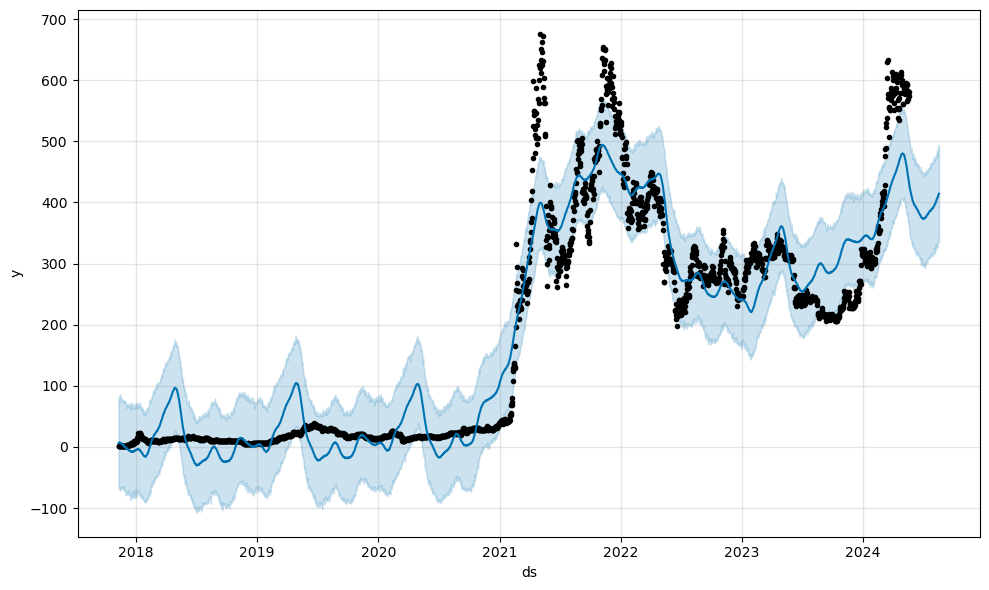

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-20,427.427360,350.856931,502.875444
2024-05-21,423.928674,343.861989,498.554576
2024-05-22,421.358241,342.731795,492.158034
2024-05-23,418.288086,340.634207,488.597630
2024-05-24,415.803393,340.426607,484.480720
...,...,...,...
2024-08-13,408.227972,331.265275,475.612067
2024-08-14,410.316103,336.687167,482.324240
2024-08-15,411.683743,339.480234,488.269129


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

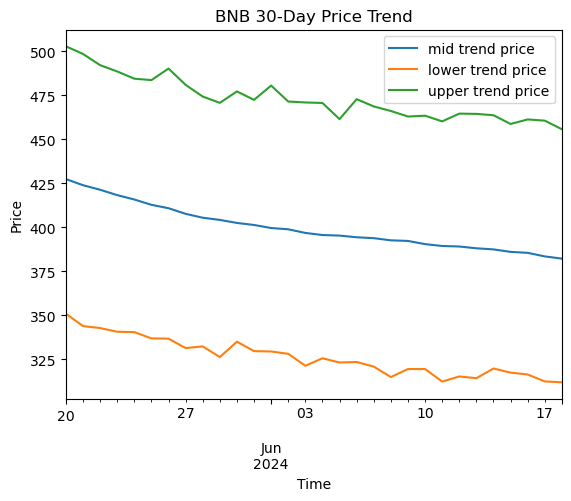

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

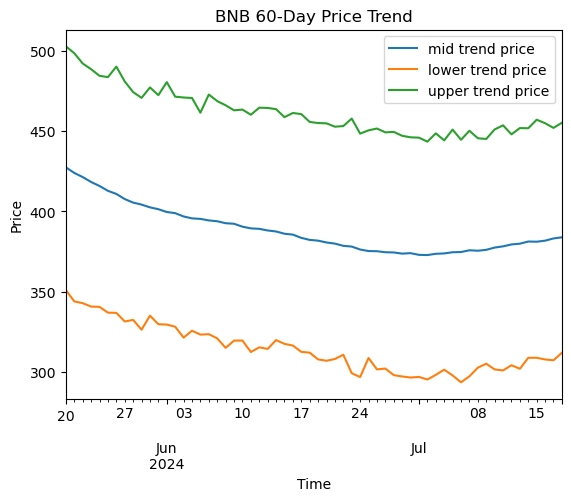

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

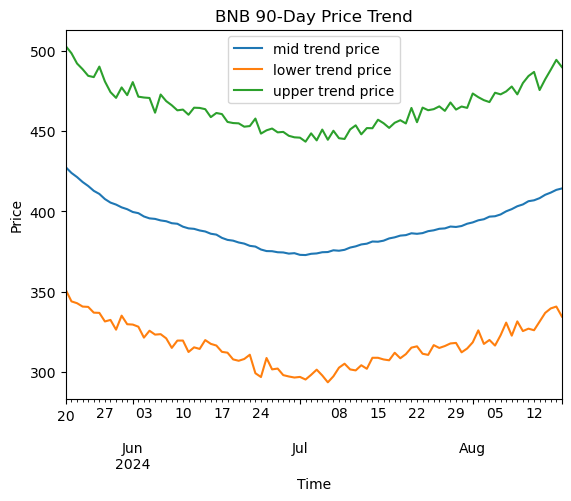

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

574.63

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

427.4273597412834

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

501.02867987064167

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

427.2028907238516

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

381.58592601005864

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

383.9641899822973

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

413.4340286854069

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.238

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.234

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

-0.175

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

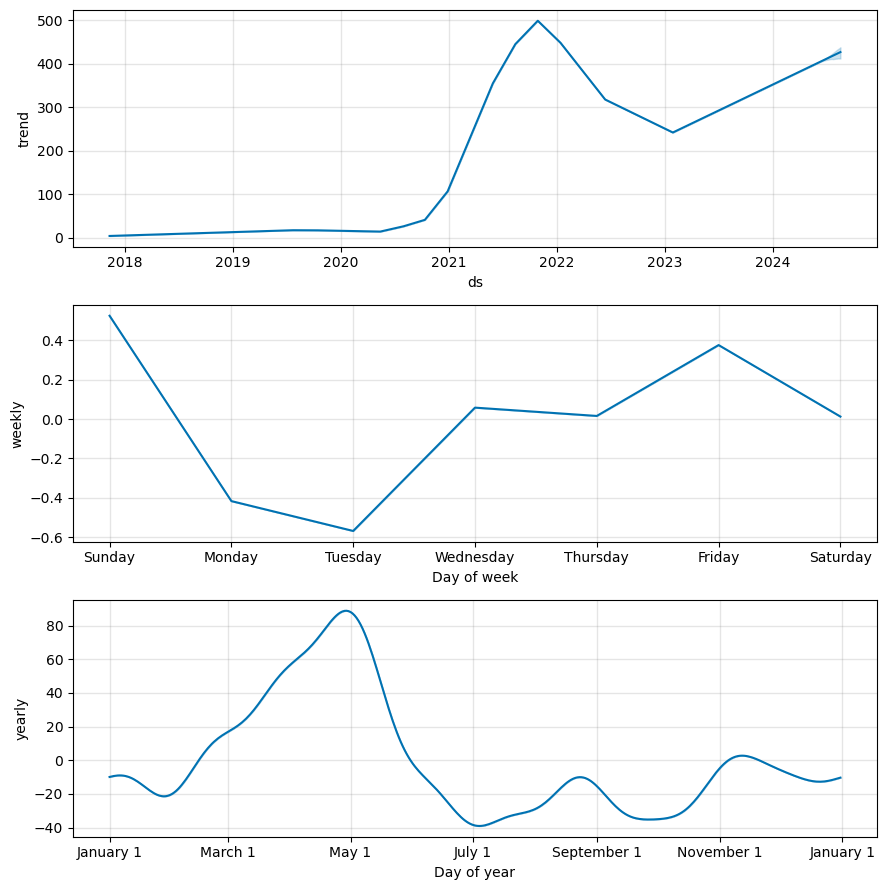

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

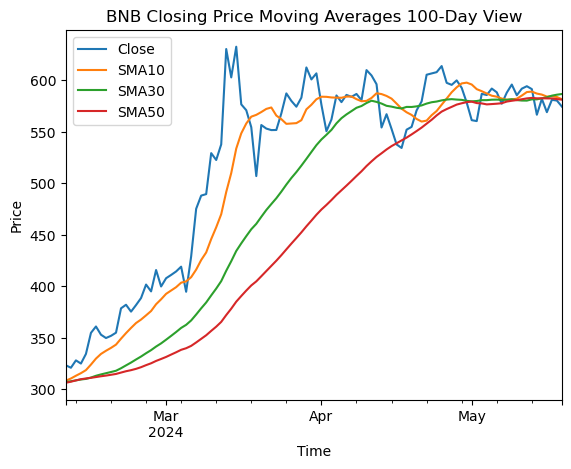

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

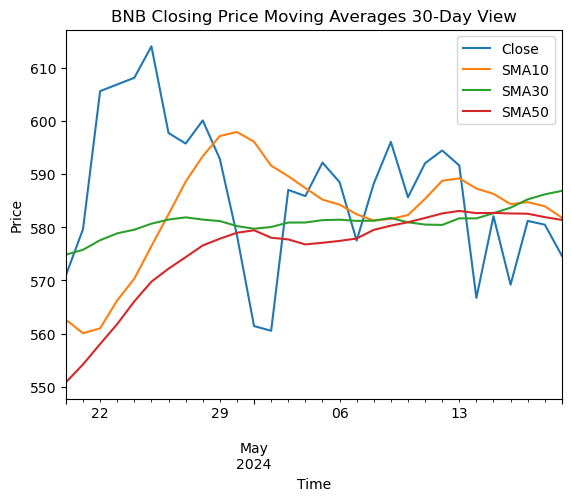

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View') 
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-20
File created :  2024-05-20.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.467602,0.016141654551261597,-0.048511607018260405,0.26698037580557354
BNB,574.63,-0.3370363083405419,-0.3290568236386213,-0.2790790471601129
BONK,2.5e-05,0.25779530706847753,0.4080859075709553,0.5429258111537147
BTC,66278.37,-0.2191180233361938,-0.1951255528263407,-0.16020045358030566
DOGE,0.149107,-0.22857973922643027,-0.28954294972299366,-0.13383869168157447
ETH,3094.12,-0.05566025624110993,-0.04356552970504457,0.046438254274701274
PEPE,9e-06,0.3163098292378519,0.5695209080409678,0.79019064181281
SHIB,2.4e-05,-0.13447450951251372,-0.07783705937680974,-0.018044767636294923
SOL,170.09,0.02993653747852032,0.09897686371903935,0.15883864333841902
XRP,0.509661,0.08170842018061886,0.1175389631277377,0.251808862234169
ADA,0.467602,-0.05356931769426376,-0.12050457682285454,0.1829944797779357
ADA,0.467602,-0.07589607234414741,-0.135242805763105,0.15993249027663747
BNB,574.63,-0.23839504335644301,-0.2336482812093087,-0.1748296149590688

